# Machine Learning in Action in Finance: Using Graphical Lasso to Identify Trading Pairs in International Stock ETFs

In [123]:
import sys
import numpy as np
import pandas as pd

symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}

In [124]:
symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print("Fetching quote history for %r" % symbol, file=sys.stderr)
    url = (
        "https://raw.githubusercontent.com/scikit-learn/examples-data/"
        "master/financial-data/{}.csv"
    )
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q["close"] for q in quotes])
open_prices = np.vstack([q["open"] for q in quotes])

# The daily variations of the quotes are what carry the most information
variation = close_prices - open_prices

Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

## Learning a graph structure
We use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others. Specifically, sparse inverse covariance gives us a graph, that is a list of connection. For each symbol, the symbols that it is connected too are those useful to explain its fluctuations.

In [125]:
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

## Clustering using affinity propagation
We use clustering to group together quotes that behave similarly. Here, amongst the various clustering techniques available in the scikit-learn, we use Affinity Propagation as it does not enforce equal-size clusters, and it can choose automatically the number of clusters from the data.

Note that this gives us a different indication than the graph, as the graph reflects conditional relations between variables, while the clustering reflects marginal properties: variables clustered together can be considered as having a similar impact at the level of the full stock market.

In [126]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, McDonald's, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 8: Kellogg, Coca Cola, Pepsi
Cluster 9: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 10: Canon, Honda, Navistar, Sony, Toyota, Xerox


## Embedding in 2D space
For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this we use Manifold learning techniques to retrieve 2D embedding. We use a dense eigen_solver to achieve reproducibility (arpack is initiated with the random vectors that we don’t control). In addition, we use a large number of neighbors to capture the large-scale structure.

In [127]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

## Visualization
The output of the 3 models are combined in a 2D graph where nodes represents the stocks and edges the:

cluster labels are used to define the color of the nodes

the sparse covariance model is used to display the strength of the edges

the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as visualization is crucial here to display the graph. One of the challenge is to position the labels minimizing overlap. For this we use an heuristic based on the direction of the nearest neighbor along each axis.

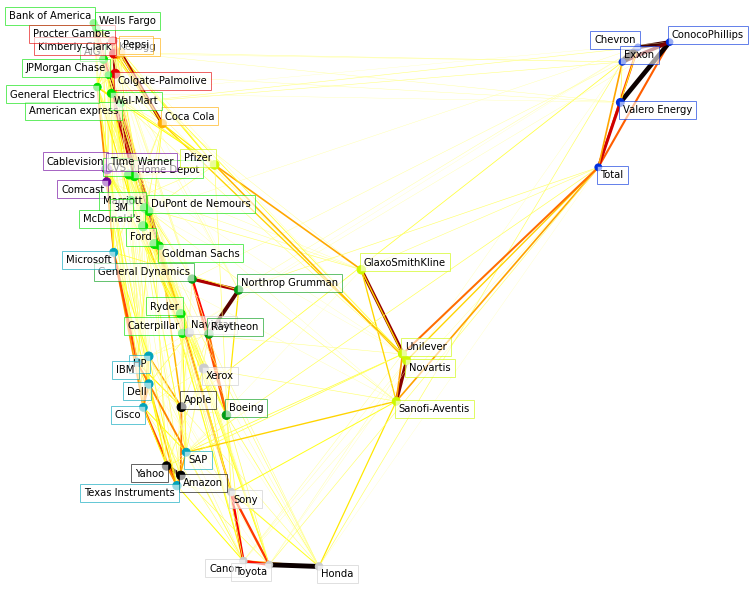

In [128]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()

## Exchange Traded Funds

In [143]:
#Setting up the mapping from ticker to country
etfs = {"EWJ":"Japan","EWZ":"Brazil",
        "FXI":"China","EWY":"South Korea",
        "EWT":"Taiwan","EWH":"Hong Kong",
        "EWC":"Canada","EWG":"Germany",
        "EWU":"United Kingdom","EWA":"Australia",
        "EWW":"Mexico","EWL":"Switzerland",
        "EWP":"Spain","EWQ":"France",
        "EIDO":"Indonesia","ERUS":"Russia",
        "EWS":"Singapore","EWM":"Malaysia",
        "EZA":"South Africa","THD":"Thailand",
        "ECH":"Chile","EWI":"Italy",
        "TUR":"Turkey","EPOL":"Poland",
        "EPHE":"Philippines","EWD":"Sweden",
        "EWN":"Netherlands","EPU":"Peru",
        "ENZL":"New Zealand","EIS":"Israel",
        "EWO":"Austria","EIRL":"Ireland","EWK":"Belgium"}

In [144]:
symbols, names = np.array(sorted(etfs.items())).T

In [153]:
pd.read_csv('Downloads/input.csv',
            header=1,
            usecols=[0,33])

,06/07/2021,22.040001
0,07/07/2021,22.049999
1,08/07/2021,21.889999
2,09/07/2021,22.230000
3,12/07/2021,22.270000
4,13/07/2021,22.250000
...,...,...
498,NaN,NaN
499,NaN,NaN
500,NaN,NaN
501,NaN,NaN


In [154]:
#df = pd.read_csv('Downloads/input.csv',
                # parse_dates={ 'date': ['year', 'month', 'day']})
#df.info()

In [155]:
#Read in series of daily closing prices
#The file 'input.csv' uses the tickers above as columns, and dates #as index in df
df = pd.read_csv("Downloads\input.csv", index_col='Date')

In [156]:
df.head(4)

,EWJ,EWZ,FXI,EWY,Taiwan.EWT,Hong.Kong.EWH,Canada.EWC,Germany.EWG,UK.EWU,Australia.EWA,...,Poland.EPOL,Philippines.EPHE,Sweden.EWD,Netherlanfs.EWN,Peru.EPU,New Zealand.ENZL,Israel.EIS,Austria.EWO,Ireland.EIRL,Belgium.EWK
Date,,,,,,,,,,,,,,,,,,,,,
06/07/2021,67.660004,38.330002,44.220001,92.320000,64.419998,26.540001,37.340000,34.410000,32.830002,25.799999,...,21.549999,30.770000,46.730000,48.020000,28.430000,1.10,69.750000,24.090000,57.959999,22.040001
07/07/2021,67.690002,38.740002,44.299999,91.580002,64.500000,26.830000,37.209999,34.750000,33.049999,26.080000,...,21.990000,30.459999,47.209999,48.279999,28.540001,1.09,69.879997,24.010000,58.189999,22.049999
08/07/2021,66.639999,38.130001,42.919998,89.540001,63.599998,26.459999,36.680000,34.279999,32.520000,25.680000,...,21.620001,30.120001,46.700001,47.419998,28.549999,1.10,68.839996,23.700001,57.040001,21.889999
09/07/2021,68.430000,38.619999,44.150002,90.209999,64.459999,26.510000,37.259998,34.919998,33.169998,26.120001,...,21.830000,29.969999,47.270000,48.189999,29.100000,1.09,69.629997,24.170000,57.910000,22.230000


## Data Processing
There is one thing we need to take care of before applying the algorithm:

In [157]:
#Convert price series to log return series
df = np.log1p(df.pct_change()).iloc[1:]

## The Core
Now we are ready to apply the algorithm:

In [158]:
#Calling Glasso algorithm
edge_model = covariance.GraphicalLassoCV(cv=10)
df /= df.std(axis=0)
edge_model.fit(df)
#the precision(inverse covariance) matrix that we want
p = edge_model.precision_

C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:316: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.658e-04
  warnings.warn(


<AxesSubplot:>

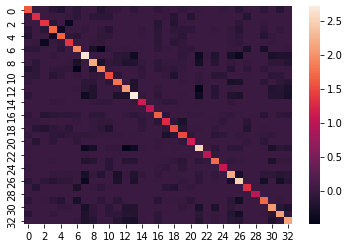

In [159]:
import seaborn as sns
sns.heatmap(p)

C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Annette.Megrvarz\Anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:316: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.658e-04
  warnings.warn(


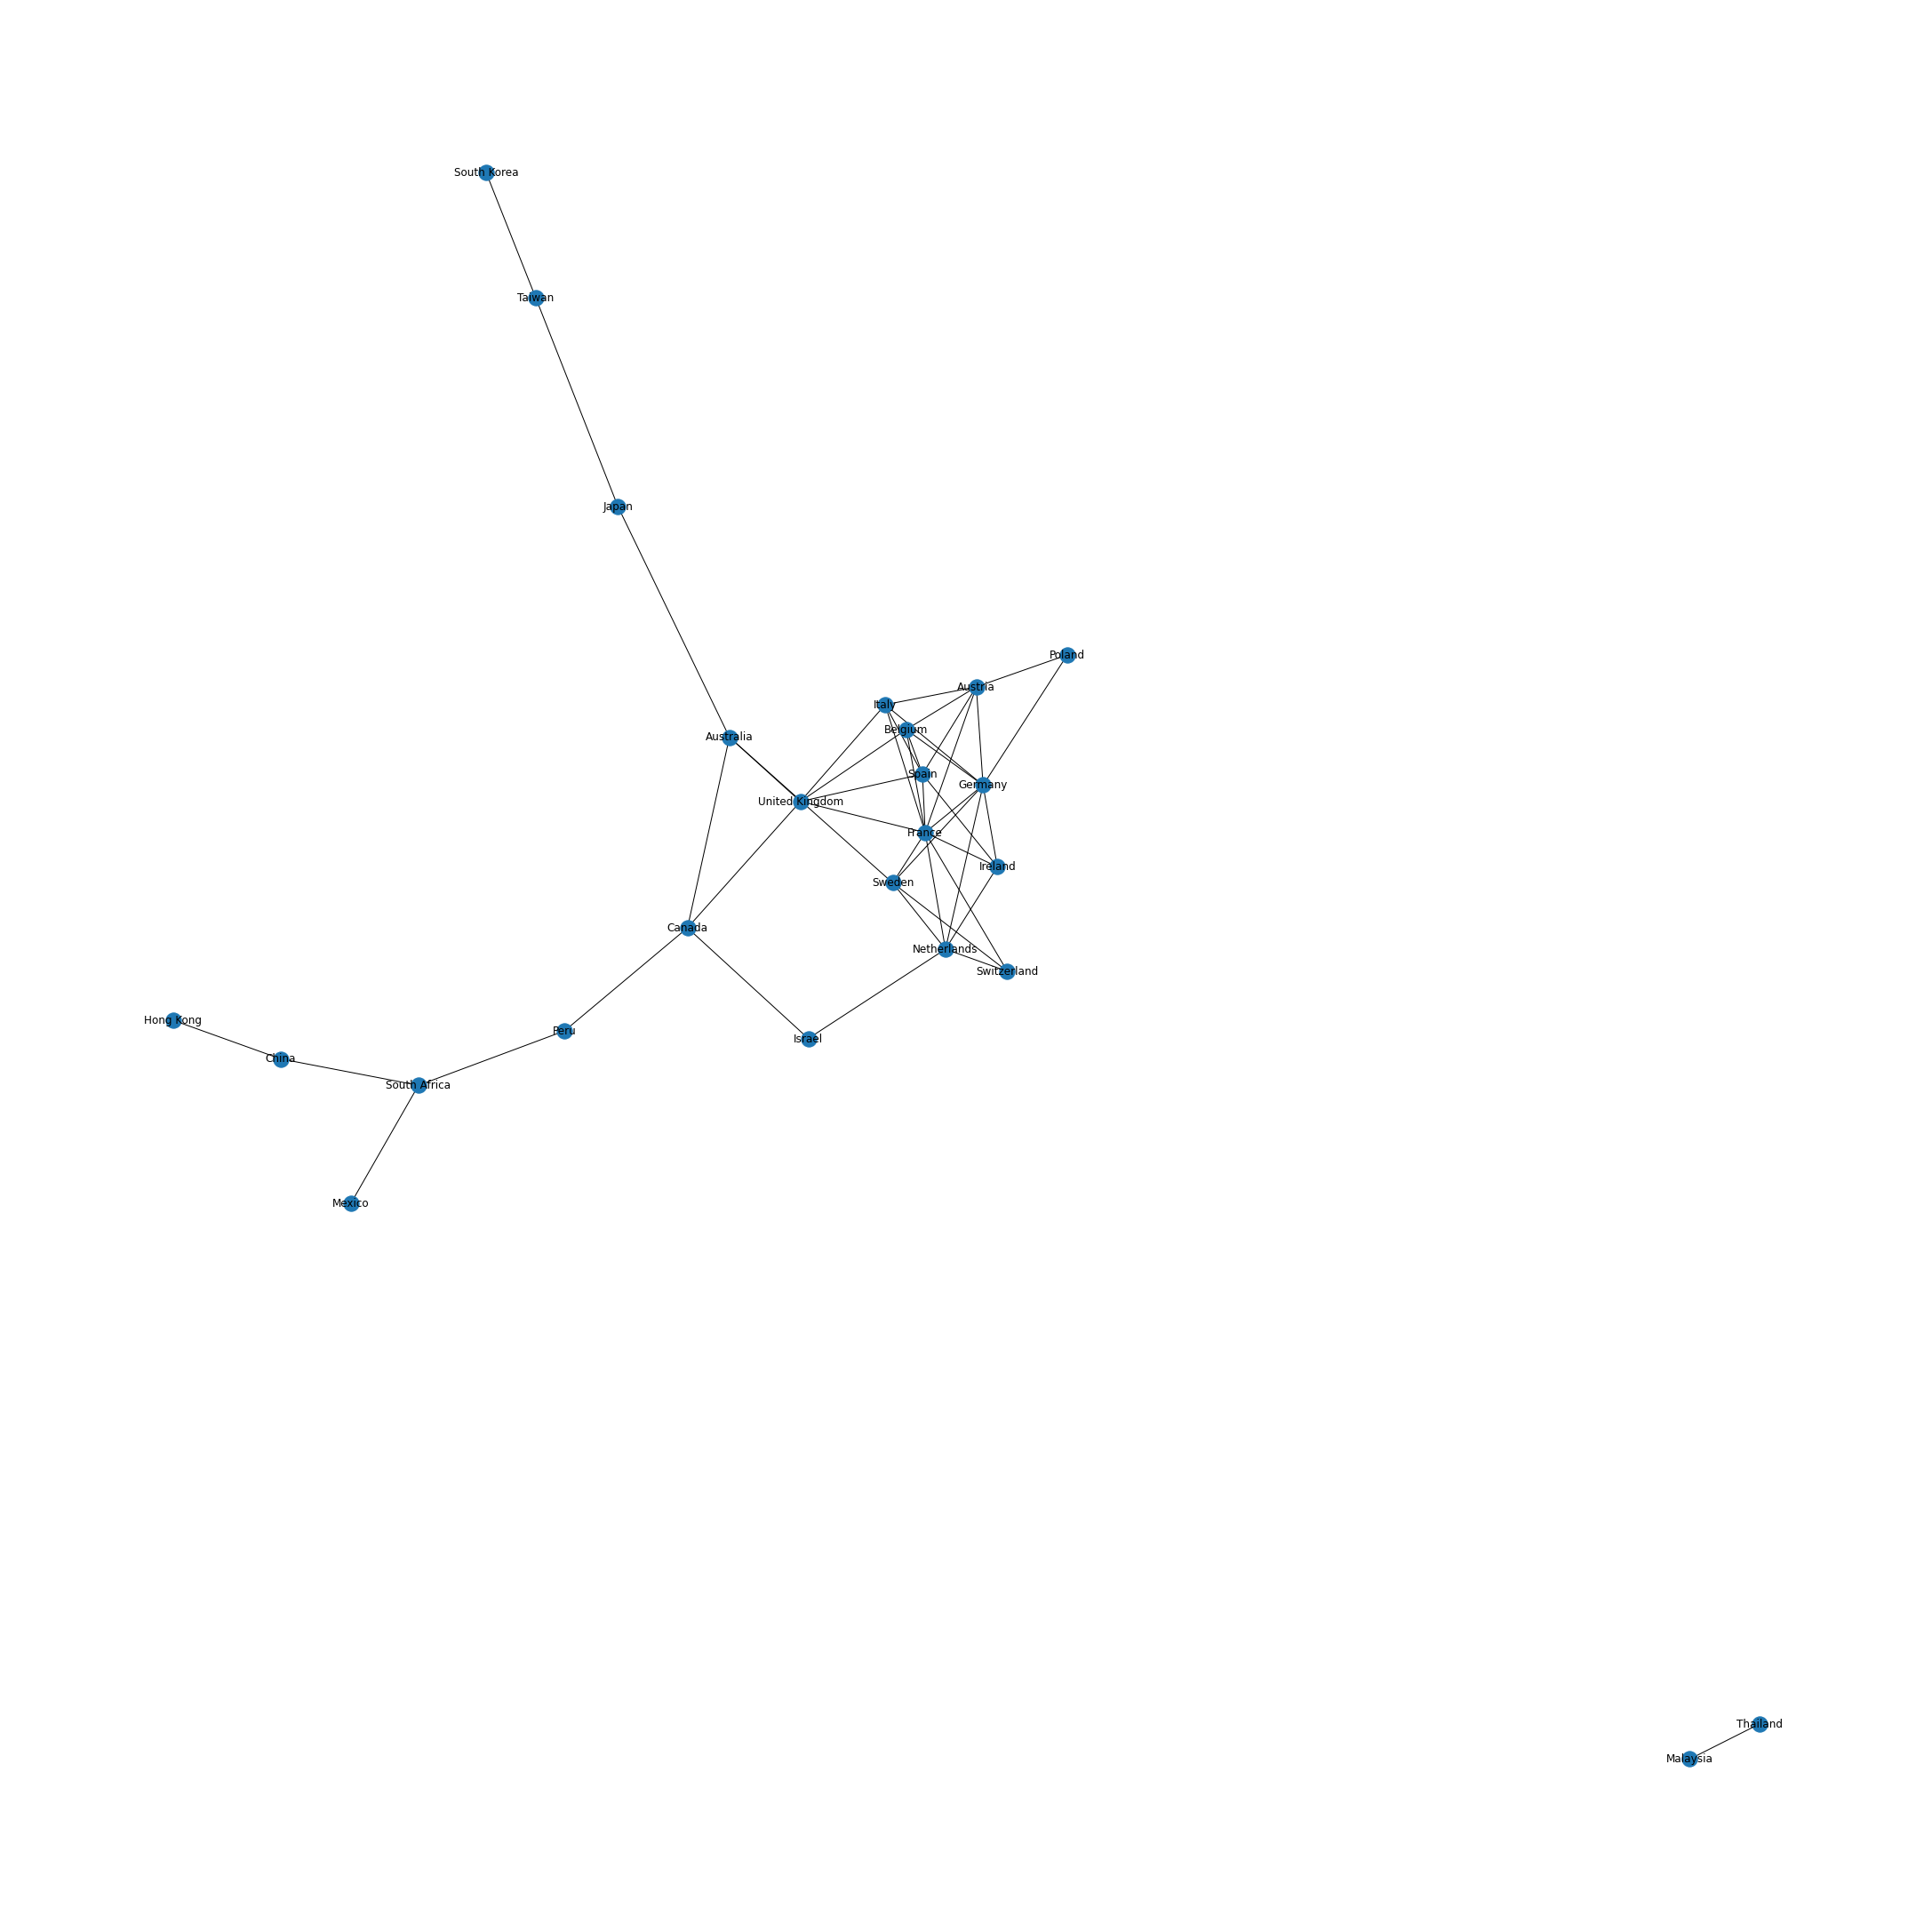

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import covariance
import numpy as np
import networkx as nx

#Setting up the mapping from ticker to country
#To be specific, we collected the daily closing price series between 04/11/2011 and 04/10/2019 from Yahoo Finance:
etfs = {"EWJ":"Japan","EWZ":"Brazil","FXI":"China","EWY":"South Korea",
"EWT":"Taiwan","EWH":"Hong Kong","EWC":"Canada","EWG":"Germany",
"EWU":"United Kingdom","EWA":"Australia","EWW":"Mexico","EWL":"Switzerland",
"EWP":"Spain","EWQ":"France","EIDO":"Indonesia","ERUS":"Russia","EWS":"Singapore",
"EWM":"Malaysia","EZA":"South Africa","THD":"Thailand",
"ECH":"Chile","EWI":"Italy","TUR":"Turkey","EPOL":"Poland","EPHE":"Philippines",
"EWD":"Sweden","EWN":"Netherlands","EPU":"Peru","ENZL":"New Zealand",
"EIS":"Israel","EWO":"Austria","EIRL":"Ireland","EWK":"Belgium"}
symbols, names = np.array(sorted(etfs.items())).T

#Read in series of daily closing prices
#The file 'input.csv' uses the tickers above as columns, and dates as index in df
df = pd.read_csv("Downloads\input.csv")
del df['Date']

#Convert price series to log return series
df = np.log1p(df.pct_change()).iloc[1:]

#Prepare the list of countries in the same order as the input columns
cols = df.columns
ctries = [etfs[c] for c in cols]
cols = pd.Series(ctries)

#Calling Glasso algorithm
edge_model = covariance.GraphicalLassoCV(cv=10)
df /= df.std(axis=0)
edge_model.fit(df)
#the precision(inverse covariance) matrix that we want
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.17) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(30, 30))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()